In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/porcelain')
mask_dir = os.path.join(dataset_dir,'mask/porcelain')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/porcelain C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/porcelain
15759
15759


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-14 23:02:44,467: INFO: 3804955329: date_time: 20250214-230244]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg16", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-14 23:02:44,612: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-14 23:02:44,612: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg16', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-14 23:02:44,613: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-14 23:02:44,613: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

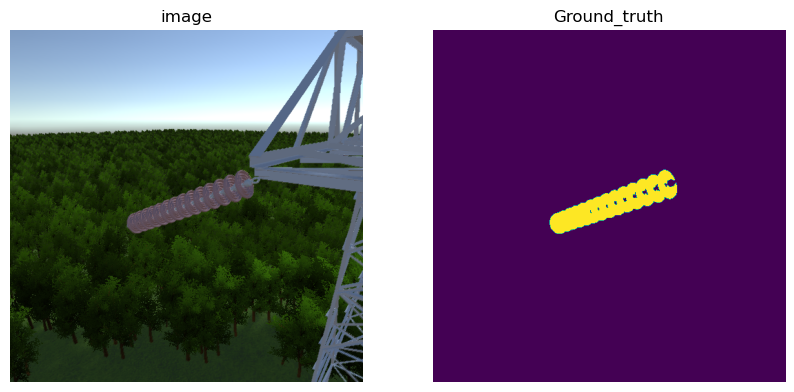

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-14 23:02:44,954: INFO: 3993860970: data injection started]
[2025-02-14 23:02:44,955: INFO: 3993860970: train data spliting ]
[2025-02-14 23:02:44,957: INFO: 3993860970: val test spliting ]
[2025-02-14 23:02:44,958: INFO: 3993860970: csv saving started]
[2025-02-14 23:02:44,977: INFO: 3993860970: train csv done ]
[2025-02-14 23:02:44,980: INFO: 3993860970: val csv done ]
[2025-02-14 23:02:44,983: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [08:45<00:00, 1.05MB/s] 


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [07:31<00:00,  4.66it/s, epoch=0, train_loss=0.0297, train_Miou_score=0.341, train_dice_score=0.729, train_acc=0.984, train_binary_jaccard_index=0.83, train_dice_coefficient=0.899] 

[2025-02-14 23:20:44,682: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02969180389203762]
[2025-02-14 23:20:44,683: INFO: 2273413975: train_loss 0.0800457152943162]
[2025-02-14 23:20:44,683: INFO: 2273413975: train_Miou_score 0.34062080668705513]
[2025-02-14 23:20:44,684: INFO: 2273413975: train_dice_score 0.7285444330066074]
[2025-02-14 23:20:44,684: INFO: 2273413975: train_acc 0.9841302123654467]
[2025-02-14 23:20:44,684: INFO: 2273413975: train_binary_jaccard_index: 0.8303906448242157]
[2025-02-14 23:20:44,685: INFO: 2273413975: train_dice_coefficient: 0.8986711032913799]



100%|██████████| 788/788 [00:31<00:00, 25.22it/s, epoch=0, eval_loss=0.00842, eval_Miou_score=0.354, eval_dice_score=0.796, eval_acc=0.992, eval_binary_jaccard_index=0.895, eval_dice_coefficient=0.938]

[2025-02-14 23:21:15,935: INFO: 2273413975: Epoch: 0 | Loss: 0.008422829324218827]
[2025-02-14 23:21:15,935: INFO: 2273413975: eval_loss 0.010618241086831147]
[2025-02-14 23:21:15,936: INFO: 2273413975: eval_Miou_score 0.35436064707881154]
[2025-02-14 23:21:15,936: INFO: 2273413975: eval_dice_score 0.7963075993043668]
[2025-02-14 23:21:15,936: INFO: 2273413975: eval_acc 0.991921364353393]
[2025-02-14 23:21:15,937: INFO: 2273413975: eval_binary_jaccard_index: 0.8948707372744373]
[2025-02-14 23:21:15,937: INFO: 2273413975: eval_dice_coefficient: 0.9382940866781277]



100%|██████████| 2102/2102 [07:31<00:00,  4.66it/s, epoch=1, train_loss=0.00798, train_Miou_score=0.352, train_dice_score=0.763, train_acc=0.988, train_binary_jaccard_index=0.865, train_dice_coefficient=0.921]

[2025-02-14 23:28:47,317: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.007982259075716492]
[2025-02-14 23:28:47,318: INFO: 2273413975: train_loss 0.044635009714126796]
[2025-02-14 23:28:47,318: INFO: 2273413975: train_Miou_score 0.35214995984856456]
[2025-02-14 23:28:47,318: INFO: 2273413975: train_dice_score 0.7634946327589162]
[2025-02-14 23:28:47,319: INFO: 2273413975: train_acc 0.988161138371413]
[2025-02-14 23:28:47,319: INFO: 2273413975: train_binary_jaccard_index: 0.864543986956028]
[2025-02-14 23:28:47,320: INFO: 2273413975: train_dice_coefficient: 0.921261181819123]



100%|██████████| 788/788 [00:31<00:00, 25.08it/s, epoch=1, eval_loss=0.00537, eval_Miou_score=0.363, eval_dice_score=0.813, eval_acc=0.993, eval_binary_jaccard_index=0.911, eval_dice_coefficient=0.949]

[2025-02-14 23:29:18,743: INFO: 2273413975: Epoch: 1 | Loss: 0.005367978197063891]
[2025-02-14 23:29:18,743: INFO: 2273413975: eval_loss 0.008136572162330708]
[2025-02-14 23:29:18,743: INFO: 2273413975: eval_Miou_score 0.3625915301420021]
[2025-02-14 23:29:18,744: INFO: 2273413975: eval_dice_score 0.81302107776501]
[2025-02-14 23:29:18,744: INFO: 2273413975: eval_acc 0.993311568565175]
[2025-02-14 23:29:18,744: INFO: 2273413975: eval_binary_jaccard_index: 0.9114193777520645]
[2025-02-14 23:29:18,745: INFO: 2273413975: eval_dice_coefficient: 0.9490392283492276]



100%|██████████| 2102/2102 [07:31<00:00,  4.66it/s, epoch=2, train_loss=0.00651, train_Miou_score=0.358, train_dice_score=0.781, train_acc=0.99, train_binary_jaccard_index=0.881, train_dice_coefficient=0.932] 

[2025-02-14 23:36:49,923: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.0065129231431164366]
[2025-02-14 23:36:49,924: INFO: 2273413975: train_loss 0.03212252706241745]
[2025-02-14 23:36:49,924: INFO: 2273413975: train_Miou_score 0.3582189376018481]
[2025-02-14 23:36:49,925: INFO: 2273413975: train_dice_score 0.781065700006814]
[2025-02-14 23:36:49,925: INFO: 2273413975: train_acc 0.9899554922845943]
[2025-02-14 23:36:49,926: INFO: 2273413975: train_binary_jaccard_index: 0.8813630752147302]
[2025-02-14 23:36:49,926: INFO: 2273413975: train_dice_coefficient: 0.9318509886491896]



100%|██████████| 788/788 [00:31<00:00, 25.35it/s, epoch=2, eval_loss=0.00451, eval_Miou_score=0.367, eval_dice_score=0.825, eval_acc=0.994, eval_binary_jaccard_index=0.921, eval_dice_coefficient=0.955]

[2025-02-14 23:37:21,012: INFO: 2273413975: Epoch: 2 | Loss: 0.004509805271468187]
[2025-02-14 23:37:21,013: INFO: 2273413975: eval_loss 0.006732527676682933]
[2025-02-14 23:37:21,013: INFO: 2273413975: eval_Miou_score 0.36733419587756877]
[2025-02-14 23:37:21,013: INFO: 2273413975: eval_dice_score 0.8250630611377294]
[2025-02-14 23:37:21,014: INFO: 2273413975: eval_acc 0.9940479015537527]
[2025-02-14 23:37:21,014: INFO: 2273413975: eval_binary_jaccard_index: 0.9210575993209069]
[2025-02-14 23:37:21,014: INFO: 2273413975: eval_dice_coefficient: 0.9548322668580894]



100%|██████████| 2102/2102 [07:30<00:00,  4.66it/s, epoch=3, train_loss=0.00538, train_Miou_score=0.362, train_dice_score=0.794, train_acc=0.991, train_binary_jaccard_index=0.893, train_dice_coefficient=0.939]

[2025-02-14 23:44:51,960: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.005378257337918631]
[2025-02-14 23:44:51,961: INFO: 2273413975: train_loss 0.025381880254498668]
[2025-02-14 23:44:51,961: INFO: 2273413975: train_Miou_score 0.36205720344113523]
[2025-02-14 23:44:51,962: INFO: 2273413975: train_dice_score 0.7941451790901194]
[2025-02-14 23:44:51,962: INFO: 2273413975: train_acc 0.9911283022014302]
[2025-02-14 23:44:51,963: INFO: 2273413975: train_binary_jaccard_index: 0.8933348430207196]
[2025-02-14 23:44:51,963: INFO: 2273413975: train_dice_coefficient: 0.9392780697055606]



100%|██████████| 788/788 [00:30<00:00, 25.42it/s, epoch=3, eval_loss=0.00422, eval_Miou_score=0.37, eval_dice_score=0.833, eval_acc=0.994, eval_binary_jaccard_index=0.927, eval_dice_coefficient=0.959] 

[2025-02-14 23:45:22,961: INFO: 2273413975: Epoch: 3 | Loss: 0.004219011455623026]
[2025-02-14 23:45:22,962: INFO: 2273413975: eval_loss 0.006123451905480153]
[2025-02-14 23:45:22,962: INFO: 2273413975: eval_Miou_score 0.36984729474920985]
[2025-02-14 23:45:22,962: INFO: 2273413975: eval_dice_score 0.8327334450858026]
[2025-02-14 23:45:22,963: INFO: 2273413975: eval_acc 0.9944854533006697]
[2025-02-14 23:45:22,963: INFO: 2273413975: eval_binary_jaccard_index: 0.9268773066962545]
[2025-02-14 23:45:22,963: INFO: 2273413975: eval_dice_coefficient: 0.9585543174430508]



100%|██████████| 2102/2102 [07:31<00:00,  4.65it/s, epoch=4, train_loss=0.00526, train_Miou_score=0.365, train_dice_score=0.802, train_acc=0.992, train_binary_jaccard_index=0.901, train_dice_coefficient=0.944]

[2025-02-14 23:52:54,698: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.005263387930041602]
[2025-02-14 23:52:54,699: INFO: 2273413975: train_loss 0.021364802216588114]
[2025-02-14 23:52:54,699: INFO: 2273413975: train_Miou_score 0.364676251006512]
[2025-02-14 23:52:54,700: INFO: 2273413975: train_dice_score 0.8022859224739469]
[2025-02-14 23:52:54,700: INFO: 2273413975: train_acc 0.9918533602958062]
[2025-02-14 23:52:54,700: INFO: 2273413975: train_binary_jaccard_index: 0.9008485090841746]
[2025-02-14 23:52:54,701: INFO: 2273413975: train_dice_coefficient: 0.9438953791778238]



100%|██████████| 788/788 [00:31<00:00, 25.09it/s, epoch=4, eval_loss=0.00505, eval_Miou_score=0.371, eval_dice_score=0.835, eval_acc=0.995, eval_binary_jaccard_index=0.929, eval_dice_coefficient=0.96] 

[2025-02-14 23:53:26,104: INFO: 2273413975: Epoch: 4 | Loss: 0.005045865468567398]
[2025-02-14 23:53:26,104: INFO: 2273413975: eval_loss 0.005966024728125657]
[2025-02-14 23:53:26,104: INFO: 2273413975: eval_Miou_score 0.3709390066923375]
[2025-02-14 23:53:26,105: INFO: 2273413975: eval_dice_score 0.8354331782012043]
[2025-02-14 23:53:26,105: INFO: 2273413975: eval_acc 0.9945817898977831]
[2025-02-14 23:53:26,105: INFO: 2273413975: eval_binary_jaccard_index: 0.9287076682211632]
[2025-02-14 23:53:26,106: INFO: 2273413975: eval_dice_coefficient: 0.9596089708339862]



100%|██████████| 2102/2102 [07:32<00:00,  4.65it/s, epoch=5, train_loss=0.00465, train_Miou_score=0.367, train_dice_score=0.809, train_acc=0.992, train_binary_jaccard_index=0.907, train_dice_coefficient=0.948]

[2025-02-15 00:00:58,465: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.004654180963871935]
[2025-02-15 00:00:58,466: INFO: 2273413975: train_loss 0.018570503919403673]
[2025-02-15 00:00:58,466: INFO: 2273413975: train_Miou_score 0.3667410175551451]
[2025-02-15 00:00:58,467: INFO: 2273413975: train_dice_score 0.8092111036869086]
[2025-02-15 00:00:58,467: INFO: 2273413975: train_acc 0.9924373241289718]
[2025-02-15 00:00:58,467: INFO: 2273413975: train_binary_jaccard_index: 0.9073448652910205]
[2025-02-15 00:00:58,468: INFO: 2273413975: train_dice_coefficient: 0.9478375463543673]



100%|██████████| 788/788 [00:31<00:00, 25.23it/s, epoch=5, eval_loss=0.00463, eval_Miou_score=0.372, eval_dice_score=0.838, eval_acc=0.995, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.961]

[2025-02-15 00:01:29,702: INFO: 2273413975: Epoch: 5 | Loss: 0.004634759072119815]
[2025-02-15 00:01:29,702: INFO: 2273413975: eval_loss 0.00575294184209343]
[2025-02-15 00:01:29,702: INFO: 2273413975: eval_Miou_score 0.3719525646072436]
[2025-02-15 00:01:29,703: INFO: 2273413975: eval_dice_score 0.8382969127673271]
[2025-02-15 00:01:29,703: INFO: 2273413975: eval_acc 0.9947144924686645]
[2025-02-15 00:01:29,704: INFO: 2273413975: eval_binary_jaccard_index: 0.9310834943498099]
[2025-02-15 00:01:29,704: INFO: 2273413975: eval_dice_coefficient: 0.9610081945002569]



100%|██████████| 2102/2102 [07:32<00:00,  4.64it/s, epoch=6, train_loss=0.00423, train_Miou_score=0.368, train_dice_score=0.815, train_acc=0.993, train_binary_jaccard_index=0.913, train_dice_coefficient=0.951]

[2025-02-15 00:09:02,251: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.00423080151586959]
[2025-02-15 00:09:02,251: INFO: 2273413975: train_loss 0.01650970695734129]
[2025-02-15 00:09:02,252: INFO: 2273413975: train_Miou_score 0.3684845040246603]
[2025-02-15 00:09:02,252: INFO: 2273413975: train_dice_score 0.814900969068925]
[2025-02-15 00:09:02,252: INFO: 2273413975: train_acc 0.992914325316242]
[2025-02-15 00:09:02,253: INFO: 2273413975: train_binary_jaccard_index: 0.9126028572418686]
[2025-02-15 00:09:02,253: INFO: 2273413975: train_dice_coefficient: 0.9510035904535457]



100%|██████████| 788/788 [00:31<00:00, 25.29it/s, epoch=6, eval_loss=0.00582, eval_Miou_score=0.373, eval_dice_score=0.838, eval_acc=0.995, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.961]

[2025-02-15 00:09:33,411: INFO: 2273413975: Epoch: 6 | Loss: 0.005820532589394429]
[2025-02-15 00:09:33,413: INFO: 2273413975: eval_loss 0.005638910747098194]
[2025-02-15 00:09:33,413: INFO: 2273413975: eval_Miou_score 0.3729586735205013]
[2025-02-15 00:09:33,413: INFO: 2273413975: eval_dice_score 0.8383660462027803]
[2025-02-15 00:09:33,414: INFO: 2273413975: eval_acc 0.9946388243937336]
[2025-02-15 00:09:33,414: INFO: 2273413975: eval_binary_jaccard_index: 0.9309041783608026]
[2025-02-15 00:09:33,415: INFO: 2273413975: eval_dice_coefficient: 0.9606482873063207]



100%|██████████| 2102/2102 [07:33<00:00,  4.63it/s, epoch=7, train_loss=0.00437, train_Miou_score=0.37, train_dice_score=0.819, train_acc=0.993, train_binary_jaccard_index=0.916, train_dice_coefficient=0.953] 

[2025-02-15 00:17:07,255: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.0043665463305109465]
[2025-02-15 00:17:07,255: INFO: 2273413975: train_loss 0.015126980272884753]
[2025-02-15 00:17:07,256: INFO: 2273413975: train_Miou_score 0.36980001657907025]
[2025-02-15 00:17:07,256: INFO: 2273413975: train_dice_score 0.8191958410154982]
[2025-02-15 00:17:07,257: INFO: 2273413975: train_acc 0.9932551671707424]
[2025-02-15 00:17:07,257: INFO: 2273413975: train_binary_jaccard_index: 0.916441785164982]
[2025-02-15 00:17:07,258: INFO: 2273413975: train_dice_coefficient: 0.9533109692641836]



100%|██████████| 788/788 [00:31<00:00, 25.00it/s, epoch=7, eval_loss=0.00413, eval_Miou_score=0.374, eval_dice_score=0.84, eval_acc=0.995, eval_binary_jaccard_index=0.933, eval_dice_coefficient=0.962] 

[2025-02-15 00:17:38,779: INFO: 2273413975: Epoch: 7 | Loss: 0.004127510308009114]
[2025-02-15 00:17:38,780: INFO: 2273413975: eval_loss 0.0054269458912039785]
[2025-02-15 00:17:38,780: INFO: 2273413975: eval_Miou_score 0.3735194285409076]
[2025-02-15 00:17:38,780: INFO: 2273413975: eval_dice_score 0.8403082313660183]
[2025-02-15 00:17:38,781: INFO: 2273413975: eval_acc 0.9947941505969479]
[2025-02-15 00:17:38,781: INFO: 2273413975: eval_binary_jaccard_index: 0.9328509952026764]
[2025-02-15 00:17:38,782: INFO: 2273413975: eval_dice_coefficient: 0.9619265070668882]



100%|██████████| 2102/2102 [07:33<00:00,  4.63it/s, epoch=8, train_loss=0.00394, train_Miou_score=0.371, train_dice_score=0.823, train_acc=0.994, train_binary_jaccard_index=0.92, train_dice_coefficient=0.955] 

[2025-02-15 00:25:12,487: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.003941172905812141]
[2025-02-15 00:25:12,488: INFO: 2273413975: train_loss 0.013885562122350965]
[2025-02-15 00:25:12,488: INFO: 2273413975: train_Miou_score 0.3709755741852965]
[2025-02-15 00:25:12,488: INFO: 2273413975: train_dice_score 0.8234262555697426]
[2025-02-15 00:25:12,489: INFO: 2273413975: train_acc 0.9935674216015002]
[2025-02-15 00:25:12,489: INFO: 2273413975: train_binary_jaccard_index: 0.9199465915197605]
[2025-02-15 00:25:12,490: INFO: 2273413975: train_dice_coefficient: 0.9554013476796231]



100%|██████████| 788/788 [00:31<00:00, 25.11it/s, epoch=8, eval_loss=0.00362, eval_Miou_score=0.374, eval_dice_score=0.843, eval_acc=0.995, eval_binary_jaccard_index=0.935, eval_dice_coefficient=0.963]

[2025-02-15 00:25:43,879: INFO: 2273413975: Epoch: 8 | Loss: 0.0036218304773272597]
[2025-02-15 00:25:43,880: INFO: 2273413975: eval_loss 0.005437151095357796]
[2025-02-15 00:25:43,880: INFO: 2273413975: eval_Miou_score 0.3741318242683759]
[2025-02-15 00:25:43,880: INFO: 2273413975: eval_dice_score 0.8434239564184047]
[2025-02-15 00:25:43,880: INFO: 2273413975: eval_acc 0.9949708138222219]
[2025-02-15 00:25:43,881: INFO: 2273413975: eval_binary_jaccard_index: 0.9352307096102684]
[2025-02-15 00:25:43,881: INFO: 2273413975: eval_dice_coefficient: 0.9633906121610147]



100%|██████████| 2102/2102 [07:33<00:00,  4.63it/s, epoch=9, train_loss=0.00366, train_Miou_score=0.372, train_dice_score=0.827, train_acc=0.994, train_binary_jaccard_index=0.923, train_dice_coefficient=0.957]

[2025-02-15 00:33:17,452: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.0036573863732712705]
[2025-02-15 00:33:17,452: INFO: 2273413975: train_loss 0.012882291802799194]
[2025-02-15 00:33:17,453: INFO: 2273413975: train_Miou_score 0.3722089635762966]
[2025-02-15 00:33:17,453: INFO: 2273413975: train_dice_score 0.8273034761630559]
[2025-02-15 00:33:17,453: INFO: 2273413975: train_acc 0.9938455560022201]
[2025-02-15 00:33:17,454: INFO: 2273413975: train_binary_jaccard_index: 0.923107043558379]
[2025-02-15 00:33:17,454: INFO: 2273413975: train_dice_coefficient: 0.9572802112765699]



100%|██████████| 788/788 [00:31<00:00, 24.79it/s, epoch=9, eval_loss=0.00306, eval_Miou_score=0.375, eval_dice_score=0.846, eval_acc=0.995, eval_binary_jaccard_index=0.938, eval_dice_coefficient=0.965]

[2025-02-15 00:33:49,245: INFO: 2273413975: Epoch: 9 | Loss: 0.0030586865498934907]
[2025-02-15 00:33:49,245: INFO: 2273413975: eval_loss 0.005216362592239675]
[2025-02-15 00:33:49,245: INFO: 2273413975: eval_Miou_score 0.374881532157152]
[2025-02-15 00:33:49,246: INFO: 2273413975: eval_dice_score 0.8462016969678101]
[2025-02-15 00:33:49,246: INFO: 2273413975: eval_acc 0.9951683175140226]
[2025-02-15 00:33:49,247: INFO: 2273413975: eval_binary_jaccard_index: 0.9376705820762037]
[2025-02-15 00:33:49,247: INFO: 2273413975: eval_dice_coefficient: 0.9648189109762234]



100%|██████████| 2102/2102 [07:34<00:00,  4.62it/s, epoch=10, train_loss=0.00351, train_Miou_score=0.373, train_dice_score=0.83, train_acc=0.994, train_binary_jaccard_index=0.926, train_dice_coefficient=0.959] 

[2025-02-15 00:41:23,890: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.00351371411251863]
[2025-02-15 00:41:23,890: INFO: 2273413975: train_loss 0.012045475559072639]
[2025-02-15 00:41:23,890: INFO: 2273413975: train_Miou_score 0.37315257329030715]
[2025-02-15 00:41:23,891: INFO: 2273413975: train_dice_score 0.8304945911927605]
[2025-02-15 00:41:23,891: INFO: 2273413975: train_acc 0.9940860164982928]
[2025-02-15 00:41:23,892: INFO: 2273413975: train_binary_jaccard_index: 0.9258845528886889]
[2025-02-15 00:41:23,892: INFO: 2273413975: train_dice_coefficient: 0.9589056675852101]



100%|██████████| 788/788 [00:31<00:00, 24.72it/s, epoch=10, eval_loss=0.0041, eval_Miou_score=0.375, eval_dice_score=0.848, eval_acc=0.995, eval_binary_jaccard_index=0.939, eval_dice_coefficient=0.965] 

[2025-02-15 00:41:55,767: INFO: 2273413975: Epoch: 10 | Loss: 0.004098809915145642]
[2025-02-15 00:41:55,767: INFO: 2273413975: eval_loss 0.005086021730960541]
[2025-02-15 00:41:55,768: INFO: 2273413975: eval_Miou_score 0.37505906715647014]
[2025-02-15 00:41:55,768: INFO: 2273413975: eval_dice_score 0.8484490343116406]
[2025-02-15 00:41:55,768: INFO: 2273413975: eval_acc 0.9952353808425459]
[2025-02-15 00:41:55,769: INFO: 2273413975: eval_binary_jaccard_index: 0.9386894482531317]
[2025-02-15 00:41:55,769: INFO: 2273413975: eval_dice_coefficient: 0.9654585050875191]



100%|██████████| 2102/2102 [07:34<00:00,  4.62it/s, epoch=11, train_loss=0.00413, train_Miou_score=0.374, train_dice_score=0.833, train_acc=0.994, train_binary_jaccard_index=0.928, train_dice_coefficient=0.96] 

[2025-02-15 00:49:30,492: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.004134933144336196]
[2025-02-15 00:49:30,493: INFO: 2273413975: train_loss 0.011418054024446992]
[2025-02-15 00:49:30,493: INFO: 2273413975: train_Miou_score 0.3738218823000623]
[2025-02-15 00:49:30,493: INFO: 2273413975: train_dice_score 0.8325333980771944]
[2025-02-15 00:49:30,494: INFO: 2273413975: train_acc 0.9942348320663325]
[2025-02-15 00:49:30,494: INFO: 2273413975: train_binary_jaccard_index: 0.9275573971337183]
[2025-02-15 00:49:30,495: INFO: 2273413975: train_dice_coefficient: 0.9599035369152557]



100%|██████████| 788/788 [00:31<00:00, 24.94it/s, epoch=11, eval_loss=0.00323, eval_Miou_score=0.375, eval_dice_score=0.85, eval_acc=0.995, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.967]  

[2025-02-15 00:50:02,095: INFO: 2273413975: Epoch: 11 | Loss: 0.003234645058660943]
[2025-02-15 00:50:02,096: INFO: 2273413975: eval_loss 0.004975051830766266]
[2025-02-15 00:50:02,096: INFO: 2273413975: eval_Miou_score 0.37534955179148594]
[2025-02-15 00:50:02,096: INFO: 2273413975: eval_dice_score 0.8503412004365616]
[2025-02-15 00:50:02,097: INFO: 2273413975: eval_acc 0.9953632354736328]
[2025-02-15 00:50:02,097: INFO: 2273413975: eval_binary_jaccard_index: 0.9404561958628724]
[2025-02-15 00:50:02,098: INFO: 2273413975: eval_dice_coefficient: 0.9665296612244118]



100%|██████████| 2102/2102 [07:34<00:00,  4.62it/s, epoch=12, train_loss=0.00344, train_Miou_score=0.375, train_dice_score=0.835, train_acc=0.994, train_binary_jaccard_index=0.93, train_dice_coefficient=0.961] 

[2025-02-15 00:57:37,091: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.003436935588816707]
[2025-02-15 00:57:37,091: INFO: 2273413975: train_loss 0.010790385484413191]
[2025-02-15 00:57:37,091: INFO: 2273413975: train_Miou_score 0.374544654815052]
[2025-02-15 00:57:37,092: INFO: 2273413975: train_dice_score 0.8350767462203446]
[2025-02-15 00:57:37,092: INFO: 2273413975: train_acc 0.9944143352453011]
[2025-02-15 00:57:37,093: INFO: 2273413975: train_binary_jaccard_index: 0.9296371511409369]
[2025-02-15 00:57:37,093: INFO: 2273413975: train_dice_coefficient: 0.9611148657244046]



100%|██████████| 788/788 [00:32<00:00, 24.07it/s, epoch=12, eval_loss=0.00656, eval_Miou_score=0.375, eval_dice_score=0.848, eval_acc=0.995, eval_binary_jaccard_index=0.939, eval_dice_coefficient=0.966]

[2025-02-15 00:58:09,835: INFO: 2273413975: Epoch: 12 | Loss: 0.0065621853177317505]
[2025-02-15 00:58:09,835: INFO: 2273413975: eval_loss 0.005104652569916293]
[2025-02-15 00:58:09,836: INFO: 2273413975: eval_Miou_score 0.3746094265941797]
[2025-02-15 00:58:09,836: INFO: 2273413975: eval_dice_score 0.8480851376728853]
[2025-02-15 00:58:09,836: INFO: 2273413975: eval_acc 0.9952159622412834]
[2025-02-15 00:58:09,837: INFO: 2273413975: eval_binary_jaccard_index: 0.9389764116876982]
[2025-02-15 00:58:09,837: INFO: 2273413975: eval_dice_coefficient: 0.9656881063275686]



100%|██████████| 2102/2102 [07:36<00:00,  4.61it/s, epoch=13, train_loss=0.00353, train_Miou_score=0.375, train_dice_score=0.837, train_acc=0.995, train_binary_jaccard_index=0.931, train_dice_coefficient=0.962]

[2025-02-15 01:05:46,164: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.003526851095322991]
[2025-02-15 01:05:46,165: INFO: 2273413975: train_loss 0.010304960909700992]
[2025-02-15 01:05:46,165: INFO: 2273413975: train_Miou_score 0.3750700294466119]
[2025-02-15 01:05:46,166: INFO: 2273413975: train_dice_score 0.836993458050517]
[2025-02-15 01:05:46,166: INFO: 2273413975: train_acc 0.994561739371748]
[2025-02-15 01:05:46,167: INFO: 2273413975: train_binary_jaccard_index: 0.9313798302328079]
[2025-02-15 01:05:46,168: INFO: 2273413975: train_dice_coefficient: 0.9621377024589034]



100%|██████████| 788/788 [00:32<00:00, 24.35it/s, epoch=13, eval_loss=0.00282, eval_Miou_score=0.375, eval_dice_score=0.85, eval_acc=0.995, eval_binary_jaccard_index=0.941, eval_dice_coefficient=0.967] 

[2025-02-15 01:06:18,533: INFO: 2273413975: Epoch: 13 | Loss: 0.0028209227898399235]
[2025-02-15 01:06:18,533: INFO: 2273413975: eval_loss 0.004916711963898136]
[2025-02-15 01:06:18,534: INFO: 2273413975: eval_Miou_score 0.3753447557709695]
[2025-02-15 01:06:18,534: INFO: 2273413975: eval_dice_score 0.8502880799964995]
[2025-02-15 01:06:18,535: INFO: 2273413975: eval_acc 0.9953564292196782]
[2025-02-15 01:06:18,535: INFO: 2273413975: eval_binary_jaccard_index: 0.940721236400987]
[2025-02-15 01:06:18,536: INFO: 2273413975: eval_dice_coefficient: 0.9667117613753018]



100%|██████████| 2102/2102 [07:34<00:00,  4.62it/s, epoch=14, train_loss=0.00336, train_Miou_score=0.376, train_dice_score=0.839, train_acc=0.995, train_binary_jaccard_index=0.933, train_dice_coefficient=0.963]

[2025-02-15 01:13:53,339: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.003355726301953636]
[2025-02-15 01:13:53,340: INFO: 2273413975: train_loss 0.009831775638196013]
[2025-02-15 01:13:53,340: INFO: 2273413975: train_Miou_score 0.3756335604112374]
[2025-02-15 01:13:53,341: INFO: 2273413975: train_dice_score 0.8389490028803703]
[2025-02-15 01:13:53,341: INFO: 2273413975: train_acc 0.9947009344342735]
[2025-02-15 01:13:53,342: INFO: 2273413975: train_binary_jaccard_index: 0.9329720405179416]
[2025-02-15 01:13:53,343: INFO: 2273413975: train_dice_coefficient: 0.9630761888042009]



100%|██████████| 788/788 [00:31<00:00, 24.93it/s, epoch=14, eval_loss=0.00416, eval_Miou_score=0.375, eval_dice_score=0.851, eval_acc=0.995, eval_binary_jaccard_index=0.941, eval_dice_coefficient=0.967]

[2025-02-15 01:14:24,950: INFO: 2273413975: Epoch: 14 | Loss: 0.004155523129526129]
[2025-02-15 01:14:24,950: INFO: 2273413975: eval_loss 0.004879370689182887]
[2025-02-15 01:14:24,950: INFO: 2273413975: eval_Miou_score 0.3754593673923294]
[2025-02-15 01:14:24,951: INFO: 2273413975: eval_dice_score 0.8513208782842443]
[2025-02-15 01:14:24,951: INFO: 2273413975: eval_acc 0.9953892149497612]
[2025-02-15 01:14:24,952: INFO: 2273413975: eval_binary_jaccard_index: 0.9412181224308391]
[2025-02-15 01:14:24,952: INFO: 2273413975: eval_dice_coefficient: 0.967048000199436]



100%|██████████| 2102/2102 [07:35<00:00,  4.62it/s, epoch=15, train_loss=0.00325, train_Miou_score=0.376, train_dice_score=0.841, train_acc=0.995, train_binary_jaccard_index=0.934, train_dice_coefficient=0.964]

[2025-02-15 01:22:00,282: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.003250601714730376]
[2025-02-15 01:22:00,283: INFO: 2273413975: train_loss 0.009403103073225018]
[2025-02-15 01:22:00,283: INFO: 2273413975: train_Miou_score 0.37618430900200495]
[2025-02-15 01:22:00,284: INFO: 2273413975: train_dice_score 0.8408106678044982]
[2025-02-15 01:22:00,284: INFO: 2273413975: train_acc 0.9948292443689161]
[2025-02-15 01:22:00,285: INFO: 2273413975: train_binary_jaccard_index: 0.9344672619032414]
[2025-02-15 01:22:00,285: INFO: 2273413975: train_dice_coefficient: 0.9639467358583155]



100%|██████████| 788/788 [00:32<00:00, 24.49it/s, epoch=15, eval_loss=0.0041, eval_Miou_score=0.375, eval_dice_score=0.851, eval_acc=0.995, eval_binary_jaccard_index=0.941, eval_dice_coefficient=0.967] 

[2025-02-15 01:22:32,463: INFO: 2273413975: Epoch: 15 | Loss: 0.004098074160856644]
[2025-02-15 01:22:32,463: INFO: 2273413975: eval_loss 0.0047962170948608815]
[2025-02-15 01:22:32,464: INFO: 2273413975: eval_Miou_score 0.37532300899824045]
[2025-02-15 01:22:32,464: INFO: 2273413975: eval_dice_score 0.8514032918622428]
[2025-02-15 01:22:32,465: INFO: 2273413975: eval_acc 0.9954219058080374]
[2025-02-15 01:22:32,465: INFO: 2273413975: eval_binary_jaccard_index: 0.9413135578675045]
[2025-02-15 01:22:32,466: INFO: 2273413975: eval_dice_coefficient: 0.9671455810060663]



100%|██████████| 2102/2102 [07:36<00:00,  4.60it/s, epoch=16, train_loss=0.00343, train_Miou_score=0.377, train_dice_score=0.842, train_acc=0.995, train_binary_jaccard_index=0.936, train_dice_coefficient=0.965]

[2025-02-15 01:30:09,344: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.003425687551498413]
[2025-02-15 01:30:09,344: INFO: 2273413975: train_loss 0.009094045144934892]
[2025-02-15 01:30:09,345: INFO: 2273413975: train_Miou_score 0.3765087439340577]
[2025-02-15 01:30:09,345: INFO: 2273413975: train_dice_score 0.8421978369086652]
[2025-02-15 01:30:09,346: INFO: 2273413975: train_acc 0.9949321890671124]
[2025-02-15 01:30:09,346: INFO: 2273413975: train_binary_jaccard_index: 0.9356794911201912]
[2025-02-15 01:30:09,347: INFO: 2273413975: train_dice_coefficient: 0.964653740713156]



100%|██████████| 788/788 [00:32<00:00, 24.29it/s, epoch=16, eval_loss=0.00363, eval_Miou_score=0.376, eval_dice_score=0.852, eval_acc=0.995, eval_binary_jaccard_index=0.942, eval_dice_coefficient=0.968]

[2025-02-15 01:30:41,785: INFO: 2273413975: Epoch: 16 | Loss: 0.0036338704642910643]
[2025-02-15 01:30:41,786: INFO: 2273413975: eval_loss 0.004722207300102225]
[2025-02-15 01:30:41,787: INFO: 2273413975: eval_Miou_score 0.3756033369760196]
[2025-02-15 01:30:41,787: INFO: 2273413975: eval_dice_score 0.8524548532096428]
[2025-02-15 01:30:41,787: INFO: 2273413975: eval_acc 0.9954777296424517]
[2025-02-15 01:30:41,788: INFO: 2273413975: eval_binary_jaccard_index: 0.942297023571149]
[2025-02-15 01:30:41,788: INFO: 2273413975: eval_dice_coefficient: 0.9677348042865938]



100%|██████████| 2102/2102 [07:36<00:00,  4.61it/s, epoch=17, train_loss=0.00315, train_Miou_score=0.377, train_dice_score=0.844, train_acc=0.995, train_binary_jaccard_index=0.937, train_dice_coefficient=0.965]

[2025-02-15 01:38:17,956: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.003147670051010306]
[2025-02-15 01:38:17,957: INFO: 2273413975: train_loss 0.008771486801918431]
[2025-02-15 01:38:17,957: INFO: 2273413975: train_Miou_score 0.3769387372888846]
[2025-02-15 01:38:17,958: INFO: 2273413975: train_dice_score 0.8436930656574099]
[2025-02-15 01:38:17,958: INFO: 2273413975: train_acc 0.9950391085246758]
[2025-02-15 01:38:17,959: INFO: 2273413975: train_binary_jaccard_index: 0.9369393279839976]
[2025-02-15 01:38:17,960: INFO: 2273413975: train_dice_coefficient: 0.9653870763962158]



100%|██████████| 788/788 [00:31<00:00, 24.93it/s, epoch=17, eval_loss=0.00293, eval_Miou_score=0.376, eval_dice_score=0.855, eval_acc=0.996, eval_binary_jaccard_index=0.944, eval_dice_coefficient=0.968]

[2025-02-15 01:38:49,572: INFO: 2273413975: Epoch: 17 | Loss: 0.002930998197061761]
[2025-02-15 01:38:49,573: INFO: 2273413975: eval_loss 0.0046224613188604775]
[2025-02-15 01:38:49,573: INFO: 2273413975: eval_Miou_score 0.37604236245907535]
[2025-02-15 01:38:49,574: INFO: 2273413975: eval_dice_score 0.8546597593121474]
[2025-02-15 01:38:49,574: INFO: 2273413975: eval_acc 0.9955662984466123]
[2025-02-15 01:38:49,575: INFO: 2273413975: eval_binary_jaccard_index: 0.9435807090810486]
[2025-02-15 01:38:49,575: INFO: 2273413975: eval_dice_coefficient: 0.9684707279779925]



100%|██████████| 2102/2102 [07:35<00:00,  4.61it/s, epoch=18, train_loss=0.00345, train_Miou_score=0.377, train_dice_score=0.845, train_acc=0.995, train_binary_jaccard_index=0.938, train_dice_coefficient=0.966]

[2025-02-15 01:46:25,431: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0034466312115358014]
[2025-02-15 01:46:25,431: INFO: 2273413975: train_loss 0.008480514918089729]
[2025-02-15 01:46:25,432: INFO: 2273413975: train_Miou_score 0.3772994810834246]
[2025-02-15 01:46:25,432: INFO: 2273413975: train_dice_score 0.8448117697257279]
[2025-02-15 01:46:25,433: INFO: 2273413975: train_acc 0.9951190954780649]
[2025-02-15 01:46:25,433: INFO: 2273413975: train_binary_jaccard_index: 0.9378674149047234]
[2025-02-15 01:46:25,434: INFO: 2273413975: train_dice_coefficient: 0.9659345137581328]



100%|██████████| 788/788 [00:32<00:00, 24.17it/s, epoch=18, eval_loss=0.00251, eval_Miou_score=0.377, eval_dice_score=0.856, eval_acc=0.996, eval_binary_jaccard_index=0.945, eval_dice_coefficient=0.969]

[2025-02-15 01:46:58,035: INFO: 2273413975: Epoch: 18 | Loss: 0.002508079491290949]
[2025-02-15 01:46:58,035: INFO: 2273413975: eval_loss 0.00451740128815961]
[2025-02-15 01:46:58,036: INFO: 2273413975: eval_Miou_score 0.376555528386237]
[2025-02-15 01:46:58,036: INFO: 2273413975: eval_dice_score 0.8559916308259174]
[2025-02-15 01:46:58,037: INFO: 2273413975: eval_acc 0.9956678662617322]
[2025-02-15 01:46:58,037: INFO: 2273413975: eval_binary_jaccard_index: 0.9446808534723861]
[2025-02-15 01:46:58,037: INFO: 2273413975: eval_dice_coefficient: 0.9691066796523844]



100%|██████████| 2102/2102 [07:36<00:00,  4.61it/s, epoch=19, train_loss=0.00305, train_Miou_score=0.378, train_dice_score=0.846, train_acc=0.995, train_binary_jaccard_index=0.939, train_dice_coefficient=0.967]

[2025-02-15 01:54:34,298: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0030478574512801094]
[2025-02-15 01:54:34,299: INFO: 2273413975: train_loss 0.008202813483768851]
[2025-02-15 01:54:34,299: INFO: 2273413975: train_Miou_score 0.37770918327340275]
[2025-02-15 01:54:34,300: INFO: 2273413975: train_dice_score 0.8460791757920461]
[2025-02-15 01:54:34,300: INFO: 2273413975: train_acc 0.9952110706848916]
[2025-02-15 01:54:34,301: INFO: 2273413975: train_binary_jaccard_index: 0.9389799704232903]
[2025-02-15 01:54:34,302: INFO: 2273413975: train_dice_coefficient: 0.9665859804788732]



100%|██████████| 788/788 [00:32<00:00, 24.37it/s, epoch=19, eval_loss=0.00652, eval_Miou_score=0.376, eval_dice_score=0.855, eval_acc=0.996, eval_binary_jaccard_index=0.943, eval_dice_coefficient=0.968]

[2025-02-15 01:55:06,635: INFO: 2273413975: Epoch: 19 | Loss: 0.006518693517912463]
[2025-02-15 01:55:06,635: INFO: 2273413975: eval_loss 0.004638097077549299]
[2025-02-15 01:55:06,635: INFO: 2273413975: eval_Miou_score 0.37621637314775497]
[2025-02-15 01:55:06,636: INFO: 2273413975: eval_dice_score 0.8553645600231488]
[2025-02-15 01:55:06,636: INFO: 2273413975: eval_acc 0.995559170887555]
[2025-02-15 01:55:06,637: INFO: 2273413975: eval_binary_jaccard_index: 0.9434550177407579]
[2025-02-15 01:55:06,637: INFO: 2273413975: eval_dice_coefficient: 0.9682486559708895]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 788/788 [00:31<00:00, 25.32it/s, loss=0.00556, Miou_score=0.37, dice_score=0.845, acc=0.994, binary_jaccard_index=0.925, dice_coefficient=0.956] 

[2025-02-15 01:55:37,778: INFO: 580206084: Test Loss: 0.005558368366986967]
[2025-02-15 01:55:37,778: INFO: 580206084: Test Miou_score: 0.36986036708361003]
[2025-02-15 01:55:37,779: INFO: 580206084: Test dice_score: 0.8453736573571179]
[2025-02-15 01:55:37,779: INFO: 580206084: Test acc: 0.9944550857931225]
[2025-02-15 01:55:37,780: INFO: 580206084: test_dice_coefficient: 0.9560692667124955]
[2025-02-15 01:55:37,780: INFO: 580206084: Test binary_jaccard_index: 0.9249587671897436]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

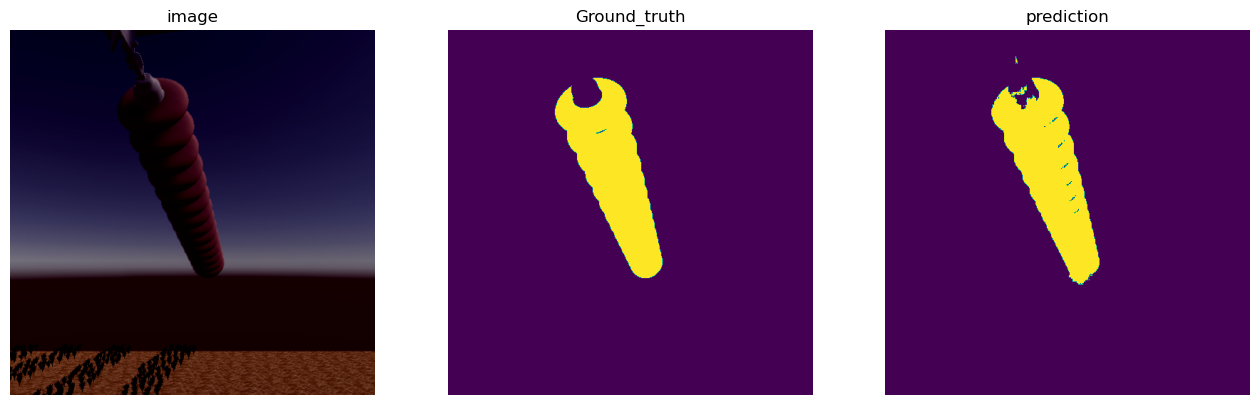

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_porcelain.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_porcelain.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_21928\2069035418.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()